In [1]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


from src.utils import import_datasets, limpar_textos, plotar_matriz_confusao, plot_roc, plot_precision_recall

In [2]:
# carregando os datasets
df_train, df_test = import_datasets()

# tratando os dados da coluna de textos
df_train["text_clean"] = df_train["text"].apply(limpar_textos)
df_test["text_clean"] = df_test["text"].apply(limpar_textos)

df_train[linhas, colunas] = (7613, 5)
Tammanho df_train = 0.29 MB
df_test[linhas, colunas] = (3263, 4)
Tamanho df_test = 0.10 MB


In [3]:
df_train.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive #wildfires evacuation or...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...


In [4]:
df_test.head()

,id,keyword,location,text,text_clean
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard about #earthquake is different cities s...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting #spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 in china and taiwan


In [5]:
y = df_train["target"]

In [6]:
X_train_split, X_val, y_train_split, y_val = train_test_split(
    df_train["text_clean"], y, test_size=0.2, stratify=y, random_state=42
)

In [7]:
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1, 2), min_df=3)

X_train_split = tfidf.fit_transform(X_train_split)
X_val = tfidf.transform(X_val)
X_test = tfidf.transform(df_test["text_clean"])

In [8]:
# Convertendo para DMatrix
dtrain = xgb.DMatrix(X_train_split, label=y_train_split)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

In [9]:
# Hiperparâmetros do modelo
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "max_depth": 6,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42,
}

In [10]:
# Treinamento com early stopping
watchlist = [(dtrain, "train"), (dval, "val")]
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=watchlist,
    early_stopping_rounds=20,
    verbose_eval=50
)

[0]	train-logloss:0.66773	val-logloss:0.67054
[50]	train-logloss:0.48393	val-logloss:0.53430
[100]	train-logloss:0.43339	val-logloss:0.50422
[150]	train-logloss:0.39799	val-logloss:0.48810
[200]	train-logloss:0.37139	val-logloss:0.47705
[250]	train-logloss:0.34871	val-logloss:0.47149
[300]	train-logloss:0.32982	val-logloss:0.46687
[350]	train-logloss:0.31287	val-logloss:0.46345
[392]	train-logloss:0.30041	val-logloss:0.46368


In [11]:
# Avaliação no conjunto de validação
val_preds = (bst.predict(dval) > 0.5).astype(int)

In [12]:
print("F1 (macro):", f1_score(y_val, val_preds, average="macro"))
print("Accuracy:", accuracy_score(y_val, val_preds))
print("Recall:", recall_score(y_val, val_preds, average="macro"))

F1 (macro): 0.7803575586192242
Accuracy: 0.7905449770190414
Recall: 0.7755988640322632


In [13]:
# Predição final no conjunto de teste
test_preds = (bst.predict(dtest) > 0.5).astype(int)

In [14]:
# Submissão no formato Kaggle
submission_xgb = pd.DataFrame({"id": df_test["id"], "target": test_preds})
submission_xgb.to_csv("resultados/submission_xgboost.csv", index=False)

# Gerando gráficos

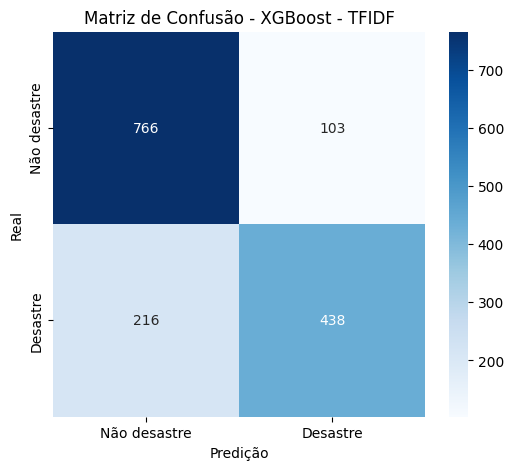

In [15]:
cm = confusion_matrix(y_val, val_preds)

plotar_matriz_confusao(cm, "XGBoost - TFIDF")

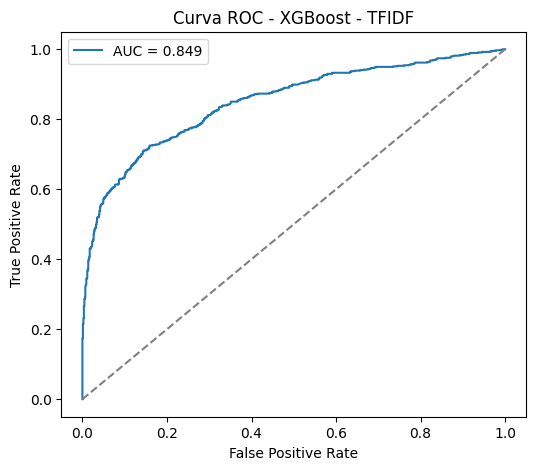

In [16]:
plot_roc(bst, dval, y_val, model_name="XGBoost - TFIDF")

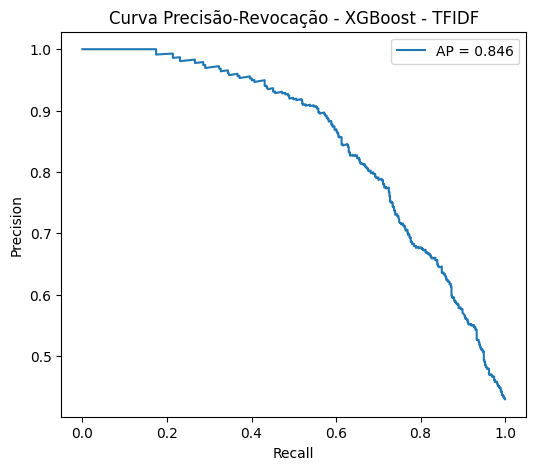

In [17]:
plot_precision_recall(bst, dval, y_val, model_name="XGBoost - TFIDF")